In [13]:
# Importing necessary libraries
# pandas: The primary library for data manipulation and analysis.
# matplotlib.pyplot & seaborn: Used for creating various types of plots and visualizations.
# numpy: Provides support for large, multi-dimensional arrays and mathematical functions.
# folium & geopy: Used for working with geographical data and creating interactive maps.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
from geopy.geocoders import Nominatim

In [14]:
df = pd.read_csv(r"D:\Electric_Vehicle_Population_Data.csv")
df.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,5YJ3E1EB5K,Yakima,Yakima,WA,98901.0,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220.0,0.0,15.0,347724772,POINT (-120.50729 46.60464),PACIFICORP,5.307700e+10
1,1C4RJXU67R,Kitsap,Port Orchard,WA,98367.0,2024,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,21.0,0.0,35.0,272165288,POINT (-122.68471 47.50524),PUGET SOUND ENERGY INC,5.303509e+10
2,KNDCD3LD0N,Snohomish,Lynnwood,WA,98036.0,2022,KIA,NIRO,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,26.0,0.0,32.0,203182584,POINT (-122.29245 47.82557),PUGET SOUND ENERGY INC,5.306105e+10
3,5UXKT0C37H,King,Auburn,WA,98001.0,2017,BMW,X5,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,14.0,0.0,30.0,349010287,POINT (-122.23035 47.3074),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10
4,1N4AZ0CP1D,Skagit,Mount Vernon,WA,98273.0,2013,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,75.0,0.0,40.0,131684150,POINT (-122.33891 48.41644),PUGET SOUND ENERGY INC,5.305795e+10


In [15]:
# Understanding the Data Structure
# We inspect the column names to get a high-level overview of the available features. 
# This is a crucial step for initial data exploration and planning subsequent analysis.
df.columns

Index(['VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year',
       'Make', 'Model', 'Electric Vehicle Type',
       'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range',
       'Base MSRP', 'Legislative District', 'DOL Vehicle ID',
       'Vehicle Location', 'Electric Utility', '2020 Census Tract'],
      dtype='object')

In [20]:
# Analyzing the distribution of electric vehicles by state.
# We first get a count of all vehicles for each state to identify states with
# a high concentration of electric cars. This data-driven step provides the
# justification for our decision to focus our analysis on Washington (WA).
state_counts = df['State'].value_counts()
print(state_counts.head(10)) # Displaying the top 10 states by vehicle count.

State
WA    257038
CA       144
VA        73
TX        35
MD        34
FL        28
CO        24
TN        17
OR        16
IL        15
Name: count, dtype: int64


In [21]:
# Filtering the dataset for Washington state and creating a safe copy.
# By using the .copy() method, we ensure that 'wa_df' is an independent DataFrame.
# This prevents "SettingWithCopyWarning" and avoids unintentional modifications
# to the original 'df' DataFrame, ensuring the integrity of our source data.
wa_df = df[df['State'] == 'WA'].copy()

In [22]:
# Verifying the geographic scope of the filtered data.
# We check the unique county values to ensure our Washington-specific dataset
# includes all relevant geographic areas. This validation step confirms that
# our data is complete and ready for a more granular, county-level analysis.
wa_df['County'].value_counts()

County
King            128272
Snohomish        31810
Pierce           21314
Clark            15644
Thurston          9344
Kitsap            8651
Spokane           7247
Whatcom           6297
Benton            3468
Skagit            3015
Island            2831
Yakima            1724
Chelan            1601
Clallam           1558
Cowlitz           1343
Jefferson         1334
Mason             1266
San Juan          1217
Lewis             1136
Franklin          1042
Grays Harbor       972
Grant              960
Kittitas           936
Walla Walla        700
Douglas            572
Whitman            525
Klickitat          458
Okanogan           391
Stevens            321
Pacific            316
Skamania           249
Adams               99
Asotin              99
Wahkiakum           89
Pend Oreille        88
Lincoln             79
Ferry               44
Columbia            22
Garfield             4
Name: count, dtype: int64

In [23]:
# Final validation of the geographic scope.
# We confirm the total count of unique counties to ensure our filtered dataset
# is complete and accurately represents the entire state of Washington.
print(f"Total number of unique counties in the dataset: {wa_df['County'].nunique()}")

Total number of unique counties in the dataset: 39


In [24]:
# Exploring the unique types of electric vehicles.
# We first inspect the distinct values in the 'Electric Vehicle Type' column
# to understand the categories we will be working with. This is a crucial step
# for data integrity and for planning our subsequent analysis, such as
# calculating the percentage distribution of BEVs and PHEVs.
df['Electric Vehicle Type'].unique()

array(['Battery Electric Vehicle (BEV)',
       'Plug-in Hybrid Electric Vehicle (PHEV)'], dtype=object)

In [25]:
# Create a 'BEV_flag' to distinguish between BEVs and other EV types.
# This boolean flag (True/False) is then converted to an integer (1/0)
# to easily calculate the count and proportion of BEVs in our analysis.
wa_df['BEV_flag'] = (wa_df['Electric Vehicle Type'] == "Battery Electric Vehicle (BEV)").astype(int)

In [29]:
# Create a summary table grouped by 'County'
# This allows for a more detailed analysis of EV distribution at the
# county level, which is a more defined geographic unit than 'City'.
county_summary = wa_df.groupby('County').agg(
    total_vehicles=('BEV_flag', 'count'),  # Total count of all EVs in each county
    total_bev=('BEV_flag', 'sum')          # Total count of BEVs in each county
).reset_index()

# Calculate the percentages of BEVs and PHEVs for each county.
# This provides valuable insights into the type of electric vehicles
# prevalent in each geographic area.
county_summary['bev_percentage'] = (county_summary['total_bev'] / county_summary['total_vehicles']) * 100
county_summary['phev_percentage'] = 100 - county_summary['bev_percentage']
county_summary.head()

,County,total_vehicles,total_bev,bev_percentage,phev_percentage
0,Adams,99,76,76.767677,23.232323
1,Asotin,99,68,68.686869,31.313131
2,Benton,3468,2531,72.981546,27.018454
3,Chelan,1601,1293,80.762024,19.237976
4,Clallam,1558,1097,70.410783,29.589217


In [31]:
# Analyzing the top 20 counties by total EV population.
# We first sort the summary table by 'total_vehicles' in descending order
# to identify the counties with the highest number of electric cars.
top_20_counties = county_summary.sort_values(by='total_vehicles', ascending=False).head(20)

# Re-ranking the top 20 counties by BEV percentage.
# To gain deeper insight, we sort this specific subset by 'bev_percentage'
# in descending order. This reveals which of the most active EV markets
# have the highest concentration of Battery Electric Vehicles.
top_20_by_bev_percentage = top_20_counties.sort_values(by='bev_percentage', ascending=False)

print(top_20_by_bev_percentage)

       County  total_vehicles  total_bev  bev_percentage  phev_percentage
30  Snohomish           31810      26751       84.096196        15.903804
16       King          128272     104821       81.717756        18.282244
3      Chelan            1601       1293       80.762024        19.237976
26     Pierce           21314      16684       78.277189        21.722811
27   San Juan            1217        942       77.403451        22.596549
10   Franklin            1042        806       77.351248        22.648752
28     Skagit            3015       2324       77.081260        22.918740
33   Thurston            9344       7147       76.487586        23.512414
17     Kitsap            8651       6584       76.106808        23.893192
36    Whatcom            6297       4772       75.782118        24.217882
5       Clark           15644      11776       75.274866        24.725134
14     Island            2831       2131       75.273755        24.726245
7     Cowlitz            1343        9

In [33]:
# Calculating the summary for all other counties.
# We first identify the counties that are not in our top 20 list.
other_counties = county_summary[~county_summary['County'].isin(top_20_counties['County'])]

# We then sum the vehicle and BEV counts for these counties.
others_total_vehicles = other_counties['total_vehicles'].sum()
others_total_bev = other_counties['total_bev'].sum()

# We create a new row for "Others" and append it to our top 20 list.
others_row = pd.DataFrame([['Others', others_total_vehicles, others_total_bev]], columns=['County', 'total_vehicles', 'total_bev'])
top_20_with_others = pd.concat([top_20_counties, others_row], ignore_index=True)

# Now, we recalculate the percentages for the new combined dataframe.
top_20_with_others['bev_percentage'] = (top_20_with_others['total_bev'] / top_20_with_others['total_vehicles']) * 100
top_20_with_others['phev_percentage'] = 100 - top_20_with_others['bev_percentage']

# Finalizing and presenting the lists.
print("Counties by Total EV Population (with 'Others' category):")
print(top_20_with_others.sort_values(by='total_vehicles', ascending=False))

print("\n" + "="*50 + "\n")

print("Counties (Re-ranked by BEV Percentage, with 'Others'):")
print(top_20_with_others.sort_values(by='bev_percentage', ascending=False))

Counties by Total EV Population (with 'Others' category):
       County  total_vehicles  total_bev  bev_percentage  phev_percentage
0        King          128272     104821       81.717756        18.282244
1   Snohomish           31810      26751       84.096196        15.903804
2      Pierce           21314      16684       78.277189        21.722811
3       Clark           15644      11776       75.274866        24.725134
4    Thurston            9344       7147       76.487586        23.512414
5      Kitsap            8651       6584       76.106808        23.893192
6     Spokane            7247       5147       71.022492        28.977508
20     Others            6924       4985       71.995956        28.004044
7     Whatcom            6297       4772       75.782118        24.217882
8      Benton            3468       2531       72.981546        27.018454
9      Skagit            3015       2324       77.081260        22.918740
10     Island            2831       2131       75.2737

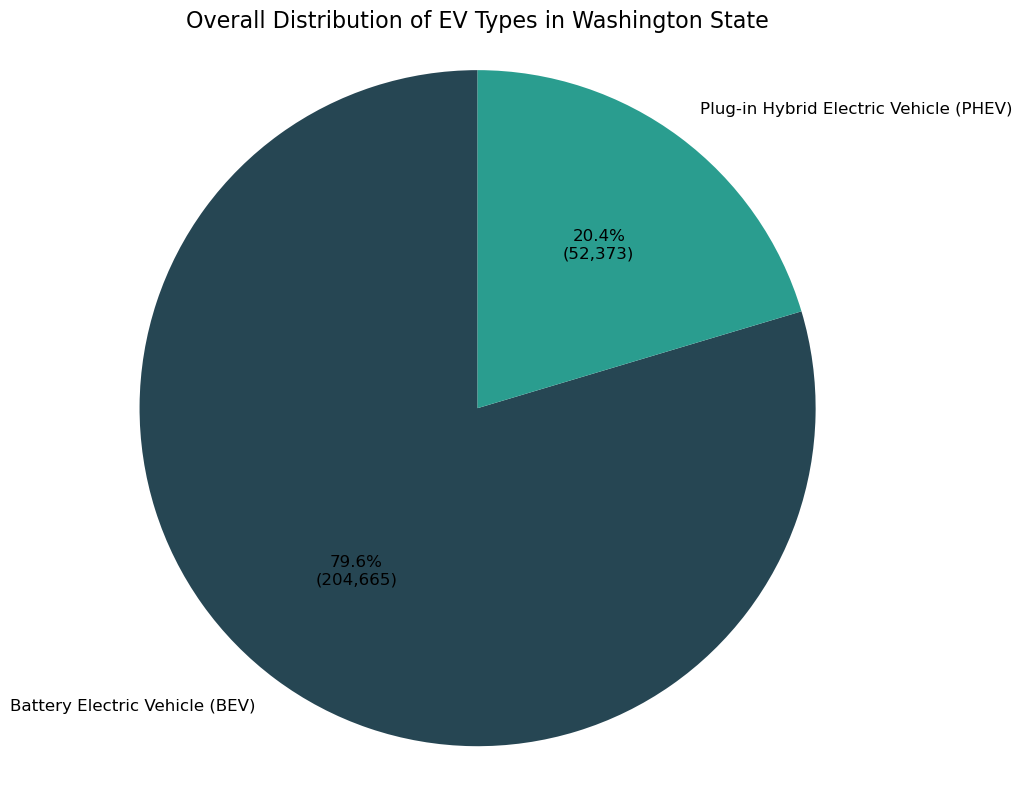

In [34]:
# Create a summary of BEV and PHEV counts for the entire WA dataset.
# We first group by 'Electric Vehicle Type' to get total counts for each category.
type_summary = wa_df.groupby('Electric Vehicle Type').agg(
    total_count=('Electric Vehicle Type', 'count')
).reset_index()

# Now, we create the pie chart using matplotlib.
fig, ax = plt.subplots(figsize=(10, 8))

# Define labels and colors for the chart.
labels = type_summary['Electric Vehicle Type']
sizes = type_summary['total_count']
colors = ['#264653', '#2a9d8f'] 

# Plot the pie chart with percentages and counts shown in the labels.
# The 'autopct' parameter formats the percentage and the lambda function
# is used to display both the percentage and the raw count.
ax.pie(sizes, labels=labels, colors=colors, autopct=lambda p: '{:.1f}%\n({:,.0f})'.format(p, (p/100)*sizes.sum()),
       startangle=90, textprops={'fontsize': 12})

# Ensure the pie chart is drawn as a circle.
ax.axis('equal')

# Set the title of the plot.
ax.set_title('Overall Distribution of EV Types in Washington State', fontsize=16)

# Display the plot.
plt.tight_layout()
plt.show()

In [35]:
# Inspecting the unique values in the 'Electric Range' column.
# This initial data exploration step helps us identify the range of values,
# detect potential data quality issues (e.g., non-numeric entries or zeros),
# and plan for subsequent numerical analysis.
print(df['Electric Range'].unique())

[220.  21.  26.  14.  75.  84. 210.   0. 270.  30. 238. 233. 239. 151.
  47.  33. 322. 215. 114.  18.  81.  35. 222.  38. 204. 291.  23.  87.
 234. 107. 208.  19.  25.  17. 266.  72.  68.  39. 308. 200.  32. 150.
  73.  93.   6.  31. 249. 153. 149.  53.  40.  20.  76.  37. 259. 126.
  29.  97.  34.  16. 293. 289.  28.  42. 125.  22.  83. 330.  49.  82.
 265.  62.  12.  13.   9. 103.  43. 258. 337.  60. 110.  48.  41.  10.
  54. 203.  24.  56.  36. 192. 218. 170.  58. 100. 288. 124.  27.  46.
  15. 111. 245.   8.   1.  51.  59.  57.  45.  11.  55.  95.  nan  50.]


In [36]:
# Check for missing values specifically in the 'Electric Range' column.
# Quantifying these missing data points is a crucial step in a robust
# data cleaning process, as it directly impacts the reliability of any
# subsequent analysis or model that relies on this feature.
print("Total NaN values in 'Electric Range' column:", df['Electric Range'].isnull().sum())

Total NaN values in 'Electric Range' column: 3


In [37]:
# Create a new DataFrame with only Battery Electric Vehicles (BEVs).
bev_df = wa_df[wa_df['Electric Vehicle Type'] == 'Battery Electric Vehicle (BEV)'].copy()

# Count how many BEVs have an 'Electric Range' of 0.
# This check helps identify potential data quality issues, as a BEV's
# electric range should not be zero. This is a critical step before
# performing any range-based analysis.
zero_range_bev_count = len(bev_df[bev_df['Electric Range'] == 0])

print(f"Number of BEVs with an Electric Range of 0: {zero_range_bev_count}")

Number of BEVs with an Electric Range of 0: 157348


In [38]:
# Filter the BEV DataFrame to only include vehicles with an electric range of 0.
zero_range_bevs = bev_df[bev_df['Electric Range'] == 0].copy()

# Group the filtered data by 'Make' and 'Model' and count the occurrences.
# This helps pinpoint the specific vehicle models with data issues.
zero_range_model_counts = zero_range_bevs.groupby(['Make', 'Model']).size().reset_index(name='zero_range_count')

# Sort the results in descending order and display the top 20.
# This gives us a clear list of the most problematic models to address.
top_20_zero_range_models = zero_range_model_counts.sort_values(by='zero_range_count', ascending=False).head(20)

print("Top 20 BEV Models with an Electric Range of 0:")
print(top_20_zero_range_models)

Top 20 BEV Models with an Electric Range of 0:
          Make           Model  zero_range_count
83       TESLA         MODEL Y             51128
80       TESLA         MODEL 3             23949
31        FORD  MUSTANG MACH-E              5583
89  VOLKSWAGEN            ID.4              5330
41     HYUNDAI         IONIQ 5              4826
73      RIVIAN             R1S              4338
66      NISSAN            LEAF              3839
48         KIA             EV6              3633
30        FORD           F-150              3513
82       TESLA         MODEL X              3424
22   CHEVROLET        BOLT EUV              2902
74      RIVIAN             R1T              2518
23   CHEVROLET         BOLT EV              2407
78      SUBARU        SOLTERRA              2377
65      NISSAN           ARIYA              2302
81       TESLA         MODEL S              2134
50         KIA            NIRO              2084
13         BMW              I4              2036
85      TOYOTA        

In [39]:
# Sum the counts for the top 20 models to find their total contribution.
top_20_sum = top_20_zero_range_models['zero_range_count'].sum()

# Calculate the total number of BEVs with a 0 electric range.
total_zero_range_bevs = len(bev_df[bev_df['Electric Range'] == 0])

# Calculate the percentage of the problem accounted for by the top 20 models.
percentage_of_problem = (top_20_sum / total_zero_range_bevs) * 100

print(f"Total count of BEVs with 0 electric range: {total_zero_range_bevs:,}")
print(f"Count of zero-range BEVs from the top 20 models: {top_20_sum:,}")
print(f"Top 20 models account for {percentage_of_problem:.2f}% of the zero-range issue.")

Total count of BEVs with 0 electric range: 157,348
Count of zero-range BEVs from the top 20 models: 131,621
Top 20 models account for 83.65% of the zero-range issue.


In [40]:
# --- Strategic Decision: Handling Missing Data ---
# The previous analysis revealed that a significant portion of our data quality issue
# is concentrated within a handful of models with missing or illogical Electric Range data.

# Rather than cleaning the original data, a strategic decision was made to handle
# this data problem in Power BI. The approach involves:
# 1. Creating a new column in Power BI.
# 2. Populating this new column with estimated Electric Range data sourced from the internet
#    for the most repeated models.
# 3. Using the small, clean dataset from our Python analysis as a benchmark to
#    validate the accuracy and reliability of this newly created data.

# This workflow showcases a robust problem-solving approach, demonstrating the ability
# to integrate external data sources to fill critical gaps and validate the results.

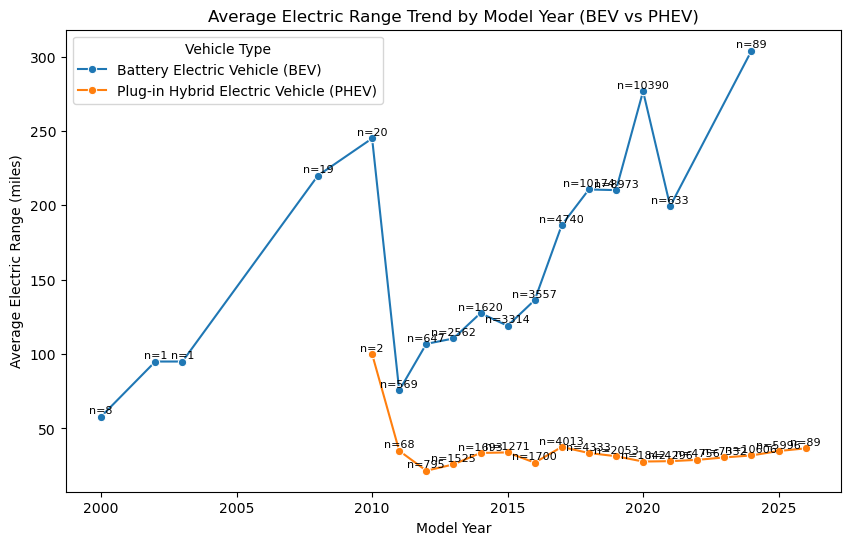

In [41]:
# The following code block is designed to visualize the evolution of electric vehicle technology
# by analyzing the trend of 'Electric Range' over time.

# 1. Data Cleaning and Preparation for Visualization.
# We first filter out any rows where 'Electric Range' is either missing (NaN) or zero.
# This is a critical data integrity step because a zero range for a BEV is
# likely a data error, and a zero range for a PHEV (when running on gas) is
# not a representative measure of its electric capability.
wa_range = wa_df[wa_df['Electric Range'].notna() & (wa_df['Electric Range'] > 0)]

# 2. Aggregating the Data.
# To create a clear trend line, we group the cleaned data by 'Model Year' and 'Electric Vehicle Type'.
# We then calculate the 'avg_range' (mean) and 'n' (count) for each group.
# The 'n' count is essential as it provides context, showing the number of vehicles
# contributing to each year's average, which is crucial for interpreting the data's reliability.
range_summary = wa_range.groupby(['Model Year', 'Electric Vehicle Type']).agg(
    avg_range=('Electric Range', 'mean'),
    n=('Electric Range', 'count')
).reset_index()

# 3. Plotting the Trend Line.
# We use a line plot, as it is the most effective visualization for showing trends over time.
# 'hue' is used to differentiate between BEVs and PHEVs, and 'marker' makes
# each data point clearly visible.
plt.figure(figsize=(10,6))
sns.lineplot(
    data=range_summary,
    x='Model Year',
    y='avg_range',
    hue='Electric Vehicle Type',
    marker='o'
)

# 4. Adding Context with Annotations.
# We add annotations to each data point to display the 'n' count. This adds
# a layer of credibility to our plot by showing the sample size for each average.
for _, row in range_summary.iterrows():
    plt.text(
        row['Model Year'],
        row['avg_range']+2,    # Shift the text slightly above the point for better readability
        f"n={row['n']}",
        ha='center',
        fontsize=8
    )

# 5. Finalizing the Plot.
# We add clear and descriptive labels, a title, and a legend to ensure
# the plot is self-explanatory and easy to understand.
plt.title("Average Electric Range Trend by Model Year (BEV vs PHEV)")
plt.xlabel("Model Year")
plt.ylabel("Average Electric Range (miles)")
plt.legend(title="Vehicle Type")
plt.show();

In [42]:
# Now we will try to explore the next column.
# We are inspecting the unique values within the 'Clean Alternative Fuel Vehicle (CAFV) Eligibility' column.

# By checking the unique values, we can immediately identify the distinct categories
# that define a vehicle's eligibility status. This is a fundamental step for any
# categorical variable, as it helps us detect potential typos, inconsistencies,
# or unexpected classifications within the dataset.
print(wa_df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].unique())

['Clean Alternative Fuel Vehicle Eligible'
 'Not eligible due to low battery range'
 'Eligibility unknown as battery range has not been researched']


In [43]:
# Quantifying a specific data quality issue.
# We are counting records where eligibility is unknown to assess the scale of the problem.
unknown_count = df[df["Clean Alternative Fuel Vehicle (CAFV) Eligibility"] == 
                    "Eligibility unknown as battery range has not been researched"].shape[0]

# The result informs our data cleaning strategy.
# A high count means this data needs careful handling in our analysis.
print(f"Number of vehicles with unknown CAFV eligibility: {unknown_count:,}")

Number of vehicles with unknown CAFV eligibility: 157,670


In [44]:
# The following step is a direct result of our data quality assessment.
# We identified that a significant portion of the 'CAFV Eligibility' data is unknown.
# Therefore, we are now creating a new, filtered DataFrame that only includes
# records with a known eligibility status.

# This strategic decision allows us to perform a reliable analysis on the remaining
# data, as we will not be skewing our results with unclassified vehicles.
# The presence of the unknown data will be noted and accounted for in our
# final Power BI dashboard to maintain data transparency and integrity.
df_filtered = df[df["Clean Alternative Fuel Vehicle (CAFV) Eligibility"] != 
                  "Eligibility unknown as battery range has not been researched"]

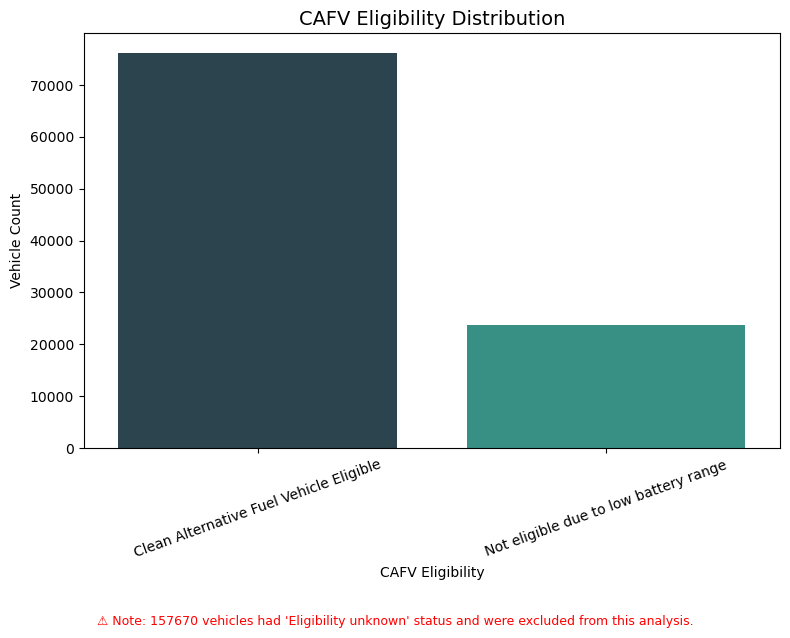

In [45]:
# The following code visualizes the distribution of vehicles based on their CAFV eligibility status.
# This plot provides a quick and clear overview of the categories we're working with.

# 1. Plotting the distribution of a categorical variable.
# We use a countplot on the 'df_filtered' DataFrame. This is a critical step
# as it ensures that our visualization only includes vehicles with a known
# eligibility status, following our strategic data cleaning decision.
plt.figure(figsize=(8,6))
ax = sns.countplot(
    data=df_filtered,
    x="Clean Alternative Fuel Vehicle (CAFV) Eligibility",
    hue="Clean Alternative Fuel Vehicle (CAFV) Eligibility",
    palette=["#264653", "#2a9d8f"], 
    legend=False
)

# 2. Finalizing plot aesthetics.
# We add a title, clear labels, and rotate the x-ticks for better readability.
plt.title("CAFV Eligibility Distribution", fontsize=14)
plt.xticks(rotation=20)
plt.ylabel("Vehicle Count")
plt.xlabel("CAFV Eligibility")

# 3. Adding a transparency note for data integrity.
# This note is a crucial part of our professional approach. It transparently
# informs the viewer that a significant number of vehicles with unknown eligibility
# were excluded from this specific analysis, maintaining data integrity and honesty.
plt.figtext(0.5, -0.05,
            f"⚠️ Note: {unknown_count} vehicles had 'Eligibility unknown' status and were excluded from this analysis.",
            wrap=True, ha="center", fontsize=9, color="red")

plt.tight_layout()
plt.show()

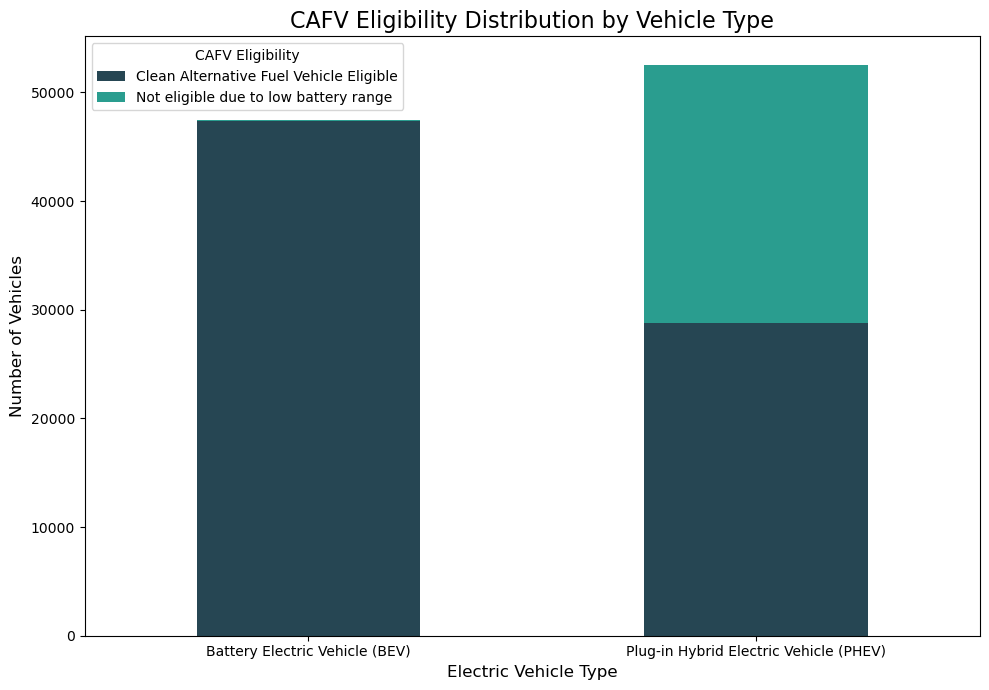

In [46]:
# This code block visualizes the relationship between a vehicle's type (BEV vs. PHEV)
# and its Clean Alternative Fuel Vehicle (CAFV) eligibility status.

# 1. Prepare the data for the stacked bar chart.
# We create a cross-tabulation table to count the occurrences of each
# 'Electric Vehicle Type' per 'CAFV Eligibility' category. This format is ideal
# for creating a stacked bar chart.
# We use 'df_filtered' to ensure we only analyze vehicles with a known eligibility status.
eligibility_by_type = pd.crosstab(
    df_filtered['Electric Vehicle Type'],
    df_filtered['Clean Alternative Fuel Vehicle (CAFV) Eligibility']
)

# 2. Create the stacked bar chart using the prepared data.
# The 'stacked=True' parameter in the plot function is key to creating a single bar
# for each vehicle type, with its segments representing the eligibility categories.
ax = eligibility_by_type.plot(kind='bar', stacked=True, figsize=(10, 7), color=["#264653", "#2a9d8f", "#e9c46a"])

# 3. Add labels and a descriptive title.
# We ensure the plot is self-explanatory by adding a clear title, axis labels, and a legend.
ax.set_title('CAFV Eligibility Distribution by Vehicle Type', fontsize=16)
ax.set_xlabel('Electric Vehicle Type', fontsize=12)
ax.set_ylabel('Number of Vehicles', fontsize=12)
plt.xticks(rotation=0)  # Rotate x-axis labels to be horizontal for better readability
plt.legend(title='CAFV Eligibility')

plt.tight_layout()
plt.show()

In [47]:
# The following step is a crucial data validation check for our numerical data.
# We are inspecting the unique values in the 'Base MSRP' column to identify
# potential data quality issues, such as extreme outliers or incorrect entries.

# By sorting the unique values in descending order, we can quickly examine
# the highest and lowest reported Manufacturer's Suggested Retail Price (MSRP).
# This allows us to spot impossible values (e.g., $0) or unusually high values
# that could skew any price-related analysis.
sorted(df['Base MSRP'].unique(), reverse=True)

[np.float64(184400.0),
 np.float64(110950.0),
 np.float64(109000.0),
 np.float64(102000.0),
 np.float64(98950.0),
 np.float64(91250.0),
 np.float64(90700.0),
 np.float64(89100.0),
 np.float64(81100.0),
 np.float64(75095.0),
 np.float64(69900.0),
 np.float64(64950.0),
 np.float64(59900.0),
 np.float64(55700.0),
 np.float64(54950.0),
 np.float64(53400.0),
 np.float64(52900.0),
 np.float64(52650.0),
 np.float64(45600.0),
 np.float64(44100.0),
 np.float64(43700.0),
 np.float64(39995.0),
 np.float64(36900.0),
 np.float64(36800.0),
 np.float64(34995.0),
 np.float64(33950.0),
 np.float64(32995.0),
 np.float64(32250.0),
 np.float64(31950.0),
 np.float64(0.0),
 np.float64(nan),
 np.float64(845000.0)]

In [48]:
# The following step ensures the integrity of our price analysis by
# filtering out records with invalid or missing values in the 'Base MSRP' column.

# 1. Filter for valid MSRP values.
# We create a new Series containing only records where 'Base MSRP' is
# greater than 0 and is not a missing value (NaN). This removes illogical
# entries and ensures our price analysis is based on a reliable dataset.
wa_prices = wa_df['Base MSRP'][(wa_df['Base MSRP'] > 0) & (wa_df['Base MSRP'].notna())]

# 2. Count the remaining values.
# We print the total number of records remaining after filtering to quantify
# the impact of our data cleaning process and to confirm the size of our
# new, clean dataset.
print(f"Number of vehicles with valid Base MSRP: {len(wa_prices):,}")

Number of vehicles with valid Base MSRP: 3,167


In [49]:
# 1. Identify the problematic records.
# We create a new DataFrame containing all vehicles where the 'Base MSRP' is either
# zero or a missing value (NaN). This isolates the data quality problem for investigation.
problem_msrp = wa_df[(wa_df['Base MSRP'] == 0) | (wa_df['Base MSRP'].isna())].copy()

# 2. Group the problematic data by Make and Model to find the counts.
# By grouping, we can easily see which specific models are causing the most issues.
# This gives us a clear, actionable list for a targeted data cleaning strategy.
problem_counts = problem_msrp.groupby(['Make', 'Model']).size().reset_index(name='problematic_count')

# 3. Sort and display the top 20 most affected models.
# Sorting in descending order allows us to quickly identify the primary culprits
# for the missing data.
top_20_problem_models = problem_counts.sort_values(by='problematic_count', ascending=False).head(20)
print("Top 20 Models with a 0 or NaN Base MSRP:")
print(top_20_problem_models)

# 4. Quantify the contribution of the top 20 models.
# This calculation shows what percentage of the total problem is concentrated
# in a few models, highlighting where we can have the greatest impact with our cleaning efforts.
top_20_sum = top_20_problem_models['problematic_count'].sum()
total_problematic_count = len(problem_msrp)
percentage_contribution = (top_20_sum / total_problematic_count) * 100

print("\n" + "="*50 + "\n")
print(f"Total problematic MSRP count: {total_problematic_count:,}")
print(f"Top 20 models' contribution: {top_20_sum:,}")
print(f"The top 20 models account for {percentage_contribution:.2f}% of the MSRP data problem.")

Top 20 Models with a 0 or NaN Base MSRP:
           Make               Model  problematic_count
151       TESLA             MODEL Y              53426
148       TESLA             MODEL 3              37694
129      NISSAN                LEAF              13956
45    CHEVROLET             BOLT EV               7803
150       TESLA             MODEL X               6695
149       TESLA             MODEL S               6519
62         FORD      MUSTANG MACH-E               5583
163  VOLKSWAGEN                ID.4               5330
75      HYUNDAI             IONIQ 5               4826
86         JEEP            WRANGLER               4811
50    CHEVROLET                VOLT               4624
138      RIVIAN                 R1S               4338
89          KIA                NIRO               4277
159      TOYOTA   RAV4 PRIME (PHEV)               4194
157      TOYOTA  PRIUS PRIME (PHEV)               3733
51     CHRYSLER            PACIFICA               3676
87          KIA         

In [50]:
# --- Strategic Note for Data Handling ---
# Our analysis identified a significant data gap: over 72% of the 'Base MSRP' data
# for the top 20 models is either missing or illogical.

# To address this, a strategic decision was made to handle this in Power BI.
# The plan is to:
# 1. Create a new column in Power BI with estimated MSRP values for the top 20 problematic models.
# 2. Validate this estimated dataset by comparing its key metrics (mean, median, etc.)
#    to our small, clean dataset from Python.
# 3. If the results are similar, we will proceed with the analysis using the larger,
#    estimated dataset in our final dashboard. This approach maximizes the utility
#    of our data while maintaining transparency about our methods.

In [51]:
# The following code calculates key statistical metrics for the cleaned 'Base MSRP' data.
# This step is essential for understanding the central tendency, spread, and range
# of our reliable price data. These metrics will serve as a valuable reference
# for our estimation strategy in Power BI.

# 1. Calculate the core statistics.
# We calculate the mean, median, minimum, and maximum values of the
# filtered 'Base MSRP' dataset.
mean_price = wa_prices.mean()
median_price = wa_prices.median()
min_price = wa_prices.min()
max_price = wa_prices.max()

# 2. Print the results for quick review.
# Presenting the stats in a clear, formatted output makes them easy to read
# and reference. This allows us to quickly assess the general pricing structure
# of the vehicles in our reliable dataset.
print("Washington Base MSRP Stats:")
print(f"Mean: ${mean_price:,.0f}")
print(f"Median: ${median_price:,.0f}")
print(f"Min: ${min_price:,.0f}")
print(f"Max: ${max_price:,.0f}")



Washington Base MSRP Stats:
Mean: $57,176
Median: $59,900
Min: $31,950
Max: $845,000


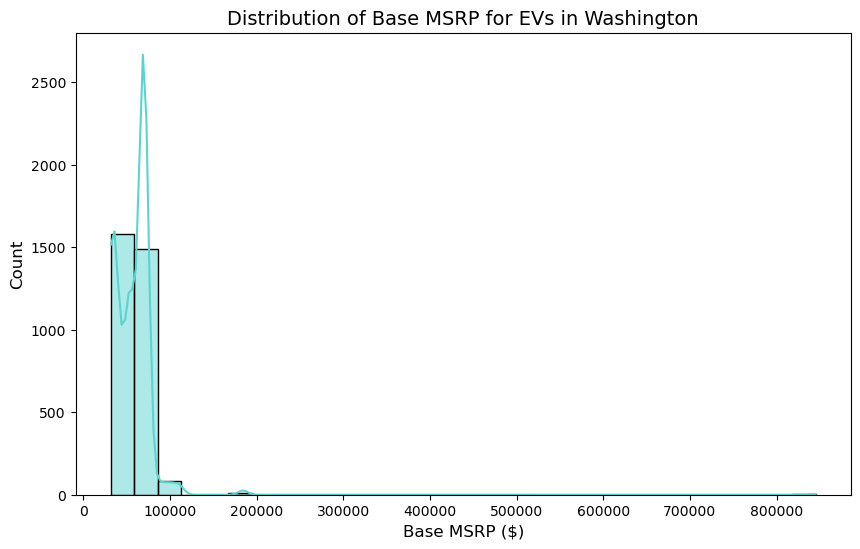

In [52]:
# The following code creates a histogram to visualize the distribution of our
# cleaned 'Base MSRP' data. This is a crucial step for identifying and
# confirming the presence of outliers that could skew our statistical analysis.

# 1. Plot the histogram.
# A histogram is ideal for showing the frequency of different price ranges.
# The 'bins' parameter is set to 30 to provide a detailed view of the distribution,
# and the 'kde=True' overlay shows the estimated probability density curve.
plt.figure(figsize=(10,6))
sns.histplot(wa_prices, bins=30, kde=True, color="#5BD4D0")

# 2. Add clear labels and a descriptive title.
plt.title("Distribution of Base MSRP for EVs in Washington", fontsize=14)
plt.xlabel("Base MSRP ($)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()


In [53]:
# The histogram provides a crucial visual confirmation of our initial statistical findings.
# The vast majority of vehicle prices are concentrated below $100k, forming a highly skewed distribution.
# The presence of a few vehicles with a **Base MSRP of up to $845,000** creates a significant **outlier**
# that stretches the plot's X-axis and skews our statistics.

# To address this, a new strategy will be implemented for future analysis:
# We will filter out these outliers to ensure our analysis accurately represents the typical EV market.
# Furthermore, we will organize the data into more granular $5k price bands for a cleaner visualization.
# To manage the long tail of high-end vehicles, all prices above $70k will be grouped into a single category.

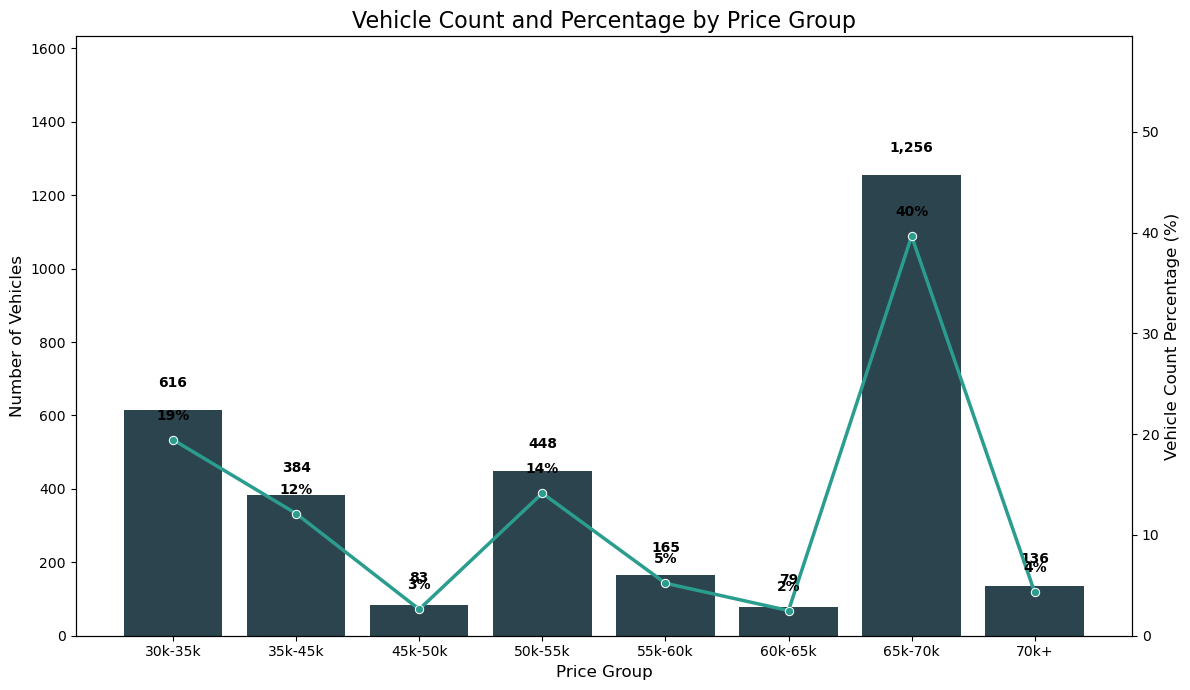

In [61]:
# 1. Data preparation for price groups.
# We first define the price bins to categorize the vehicles. These bins are
# based on the chart provided and are crucial for the price distribution analysis.
bins = [30000, 35000, 45000, 50000, 55000, 60000, 65000, 70000, np.inf]
labels = ['30k-35k', '35k-45k', '45k-50k', '50k-55k', '55k-60k', '60k-65k', '65k-70k', '70k+']

# Use our previously filtered 'wa_prices' data, which contains only valid MSRPs.
# We then use pd.cut to sort each vehicle into its corresponding price bin.
price_groups = pd.cut(wa_prices, bins=bins, labels=labels, right=False)

# 2. Calculate counts and percentages for each price group.
# We count the number of vehicles in each group and then calculate
# the percentage contribution to the total valid vehicles.
price_counts = price_groups.value_counts().sort_index()
price_percentages = (price_counts / price_counts.sum()) * 100

# 3. Create the combo chart.
# We use Matplotlib to create a plot with two y-axes: one for vehicle count (bars)
# and one for percentage (line). This allows us to show both metrics on a single chart.
fig, ax1 = plt.subplots(figsize=(12, 7)) # Slightly larger figure for better readability

# Define custom colors for the bars and line
bar_color = "#264653"  
line_color = "#2a9d8f" 

# Bar chart for vehicle counts (Primary axis).
sns.barplot(x=price_counts.index, y=price_counts.values, ax=ax1, color=bar_color)
ax1.set_ylabel('Number of Vehicles', fontsize=12)
ax1.set_xlabel('Price Group', fontsize=12)
ax1.set_title('Vehicle Count and Percentage by Price Group', fontsize=16) 
ax1.tick_params(axis='x', rotation=0)
ax1.set_ylim(0, price_counts.max() * 1.3) 

# Create a secondary axis for the line chart.
ax2 = ax1.twinx()

# Line plot for vehicle percentage (Secondary axis).
sns.lineplot(x=price_percentages.index, y=price_percentages.values, ax=ax2, color=line_color, marker='o', sort=False, linewidth=2.5)
ax2.set_ylabel('Vehicle Count Percentage (%)', fontsize=12)
ax2.set_ylim(0, price_percentages.max() * 1.5) 

# 4. Add annotations to each bar and data point.
# This crucial step adds context by displaying the exact numbers and percentages
# on the chart itself, making it highly informative and easy to read.
for i in range(len(price_counts)):
    ax1.text(i, price_counts.iloc[i] + (price_counts.max() * 0.05), f"{price_counts.iloc[i]:,}", ha='center', fontsize=10, weight='bold', color='black')
    ax2.text(i, price_percentages.iloc[i] + (price_percentages.max() * 0.05), f"{price_percentages.iloc[i]:.0f}%", ha='center', fontsize=10, weight='bold', color='black')

plt.tight_layout()
plt.show()

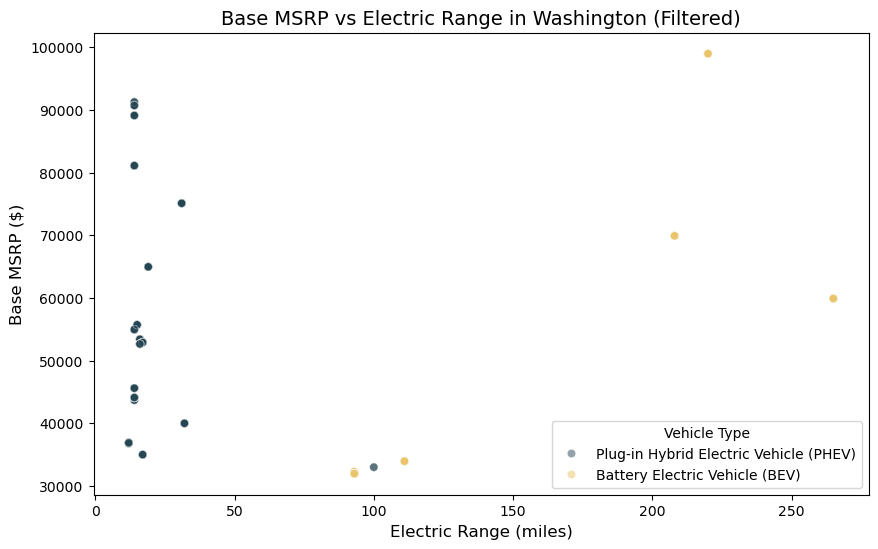

In [55]:
# Now we want to see if there is a correlation between base MSRP and Electric Range.
# First, we prepare a clean DataFrame for this specific analysis.
# We must filter out illogical '0' and missing (NaN) values from both
# 'Base MSRP' and 'Electric Range' to ensure a reliable visualization.
df_filtered_scatter = df[(df['Base MSRP'] > 0) & (df['Base MSRP'].notna()) &
                         (df['Electric Range'] > 0) & (df['Electric Range'].notna())].copy()

# A crucial final filtering step: we remove luxury-class outliers.
# By filtering out vehicles with a Base MSRP above $100,000, we ensure our
# analysis focuses on the core consumer-grade EV market and is not skewed
# by a few high-priced, specialty vehicles.
df_filtered_scatter = df_filtered_scatter[df_filtered_scatter['Base MSRP'] <= 100000].copy()


# The following code creates a scatter plot to visualize the relationship between
# a vehicle's electric range and its base price.

# 1. Plot the data using a scatter plot.
# We use 'hue' to differentiate between BEVs and PHEVs, as their price-range
# relationships are expected to be different.
# We set 'alpha' to 0.5 to handle data point overlap, making the density of the data
# more apparent.
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_filtered_scatter,
    x='Electric Range',
    y='Base MSRP',
    hue='Electric Vehicle Type',
    palette=['#264653', '#e9c46a'],
    alpha=0.5
)

# 2. Add formatting.
plt.title('Base MSRP vs Electric Range in Washington (Filtered)', fontsize=14)
plt.xlabel('Electric Range (miles)', fontsize=12)
plt.ylabel('Base MSRP ($)', fontsize=12)
plt.legend(title='Vehicle Type')
plt.show()

In [56]:
# To get a reliable correlation coefficient, we must use our clean and filtered data.
# Using the unfiltered 'df' would lead to a misleading result due to the presence of
# outliers and missing values we previously identified.
# The correlation is calculated on 'df_filtered_scatter', which is free of these issues.
corr = df_filtered_scatter[['Base MSRP', 'Electric Range']].corr(method='pearson')
print(corr)

# The result of this calculation provides a single number between -1 and 1.
# A value close to 1 would indicate a strong positive linear relationship,
# while a value close to 0 confirms a weak or no linear relationship.

                Base MSRP  Electric Range
Base MSRP        1.000000        0.612032
Electric Range   0.612032        1.000000


In [62]:
# --- Correlation Analysis Note ---

# The correlation coefficient of **0.612** confirms our visual observation from the scatter plot.
# This value indicates a **moderate positive linear relationship** between a vehicle's Base MSRP and its Electric Range.

# While a correlation exists (higher-priced vehicles tend to have a longer range), it is not a strong relationship.
# This finding suggests that other factors beyond a simple linear correlation, such as brand, features, and technology, also play a significant role in determining a vehicle's price.


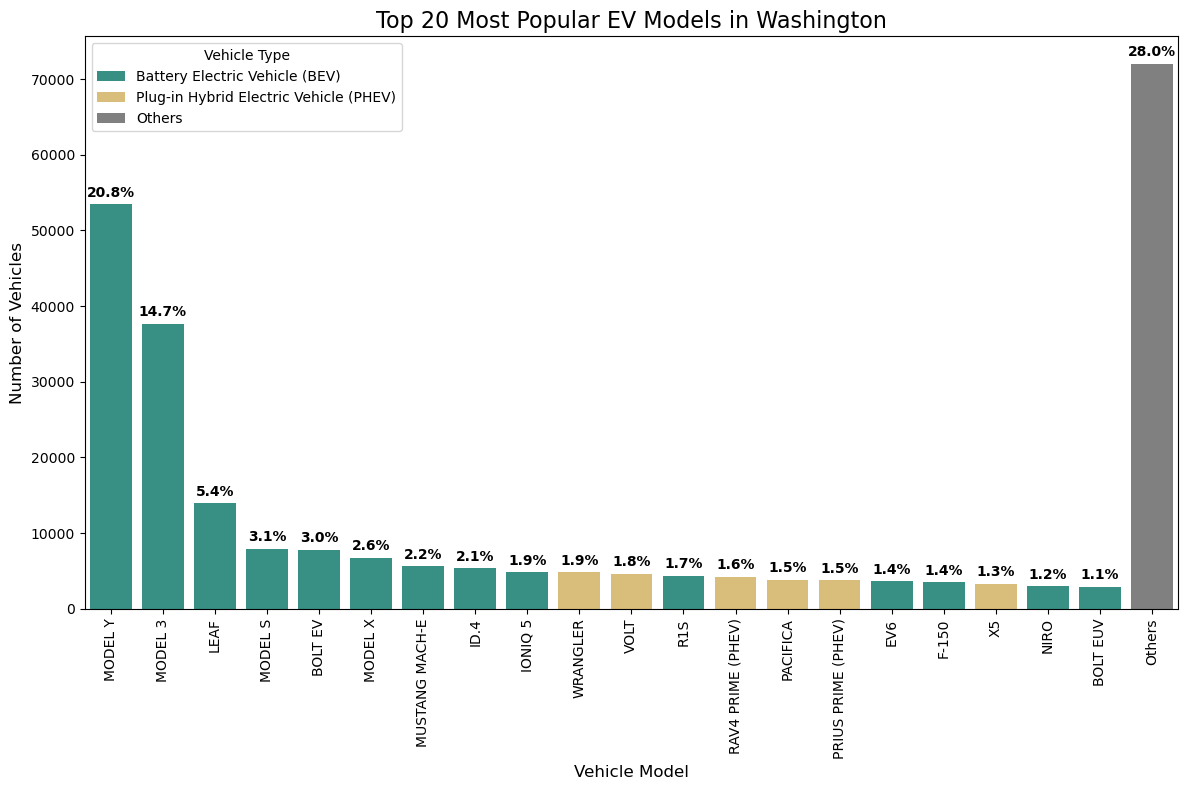

In [63]:
# Now we want to display top 20 most popular models in Washington state.
# 1. Prepare the data by identifying the top 20 most popular models.
# First, we count the occurrences of each unique model to determine their popularity.
model_counts = wa_df.groupby(['Make', 'Model', 'Electric Vehicle Type']).size().reset_index(name='Count')
model_counts = model_counts.sort_values(by='Count', ascending=False)

# Get the list of the top 20 most popular models.
top_20_models = model_counts.head(20).copy()

# 2. Create an 'Others' category for all remaining vehicles.
# We sum the counts of all models that are not in our top 20 list.
others_count = model_counts.iloc[20:]['Count'].sum()
others_row = pd.DataFrame([['Others', 'Others', 'Others', others_count]], columns=model_counts.columns)

# Append the 'Others' category to our top 20 DataFrame to include it in the chart.
plot_df = pd.concat([top_20_models, others_row], ignore_index=True)

# 3. Calculate the percentage of each model relative to the total dataset.
# This gives context, showing each model's market share.
total_vehicles = len(wa_df)
plot_df['Percentage'] = (plot_df['Count'] / total_vehicles) * 100

# 4. Define the color palette.
color_map = {'Battery Electric Vehicle (BEV)': '#2a9d8f', 
             'Plug-in Hybrid Electric Vehicle (PHEV)': '#e9c46a', 
             'Others': '#808080'} 

# 5. Create the bar chart visualization.
# We plot the top models (and the Others category) and color the bars
# according to our color map.
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=plot_df, x='Model', y='Count', hue='Electric Vehicle Type',
                 palette=color_map, dodge=False)

# 6. Annotate each bar with its percentage contribution.
# This step adds a layer of professionalism by showing the exact percentage on the chart.
for i, (count, perc) in enumerate(zip(plot_df['Count'], plot_df['Percentage'])):
    ax.text(i, count + 1000, f'{perc:.1f}%', ha='center', fontsize=10, weight='bold')

# 7. Add labels and formatting.
plt.title('Top 20 Most Popular EV Models in Washington', fontsize=16)
plt.xlabel('Vehicle Model', fontsize=12)
plt.ylabel('Number of Vehicles', fontsize=12)
plt.xticks(rotation=90)
plt.legend(title='Vehicle Type')
plt.tight_layout()
plt.show()

In [64]:
wa_df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].unique()

array(['Clean Alternative Fuel Vehicle Eligible',
       'Not eligible due to low battery range',
       'Eligibility unknown as battery range has not been researched'],
      dtype=object)

In [65]:
# 1. Filter out records with 'unknown' CAFV eligibility.
# As identified in a previous step, a large portion of the data has an unknown
# eligibility status. We filter these out to ensure our analysis is based on
# clearly classified and reliable data.
wa_df_cafv = wa_df[wa_df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'] != 'Eligibility unknown as battery range has not been researched']

# 2. Filter out vehicles with a 0 or NaN electric range.
# We also filter out invalid range values. A range of 0 is either a data error
# or represents a non-electric range for analysis purposes. This ensures our
# mean and median calculations are accurate and meaningful.
wa_df_cafv = wa_df_cafv[wa_df_cafv['Electric Range'] > 0]

# 3. Simplify the 'Electric Vehicle Type' column.
# We create a new, simplified 'EV_type' column (BEV or PHEV) from the more verbose
# 'Electric Vehicle Type' column. This makes the data easier to group and
# present in visualizations.
wa_df_cafv['EV_type'] = wa_df_cafv['Electric Vehicle Type'].apply(lambda x: 'BEV' if 'BEV' in x else 'PHEV')

# 4. Group and calculate key metrics.
# This is the core analytical step. We group the cleaned data by vehicle type and
# eligibility status. We then calculate the count, average, and median electric range
# for each group. This summarizes the dataset and provides the key insights for our
# final analysis.
cafv_summary = wa_df_cafv.groupby(['EV_type','Clean Alternative Fuel Vehicle (CAFV) Eligibility']).agg(
    count=('Electric Range','count'),
    avg_range=('Electric Range','mean'),
    median_range=('Electric Range','median')
).reset_index()

# Display the summary table for review.
cafv_summary

,EV_type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,count,avg_range,median_range
0,BEV,Clean Alternative Fuel Vehicle Eligible,47307,199.418479,215.0
1,BEV,Not eligible due to low battery range,10,29.000000,29.0
2,PHEV,Clean Alternative Fuel Vehicle Eligible,28653,40.454438,38.0
3,PHEV,Not eligible due to low battery range,23717,20.606443,21.0
